# Flight Delays

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Overview

This project involves analyzing flight data from a large travel agency and trying to predict whether or not a flight will be canceled based on several factors.  The data includes a variable called 'Canceled' that will act as the response variable.  The other variables provided include the month of the flight, the departure time, the unique carrier code, the scheduled length of the flight in minutes, the arrival delay, thee departure delay, and the distance in miles of the flight.

|Field|Data Type|Description|Type of Variable|Variable Category|
|-|-|-|-|-|
|Canceled|Binary|Canceled = 1|Target|Categorical|
|Month|Integer|Jan = 1|Predictor|Ordinal|
|DepartureTime|Integer|Military Time (1:00 PM  = 1300)|Predictor|Continuous|
|UniqueCarrier|String|Airline Carrier Code|Predictor|Categorical|
|SchedElapsedTime|Integer|Scheduled flight time in minutes|Predictor|Continuous|
|ArrDelay|Integer|Arrival delay in minutes||Continuous|
|DepDelay|Integer|Departure delay in minutes||Continuous|
|Distance|Integer|Distance in miles|Predictor|Continuous|

One thing to note is that ArrDelay and DepDelay cannot be calculated until after a flight either takes off or is cancelled.  Since our objective is to predict whether a future flight will be cancelled or not, we will not have these metrics available to us and should not include them in any models.  

We will also most likely need to convert the UniqueCarrier variable to one-hot encoded dummy variables in order to include this metric in the model.

In [2]:
headers = ['Canceled','Month','DepartureTime','UniqueCarrier','SchedElapsedTime','ArrDelay','DepDelay','Distance']

df = pd.read_csv('Data/Data_PredictingFlightDelays.csv',names=headers)

In [3]:
df.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
0,1,12,814,UA,134,0,0,679
1,1,12,830,DL,90,0,0,214
2,1,1,1835,UA,213,0,0,1605
3,1,4,1730,AA,80,0,0,235
4,1,7,1442,UA,103,0,0,413


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
Canceled            6000 non-null int64
Month               6000 non-null int64
DepartureTime       6000 non-null int64
UniqueCarrier       6000 non-null object
SchedElapsedTime    6000 non-null int64
ArrDelay            6000 non-null int64
DepDelay            6000 non-null int64
Distance            6000 non-null int64
dtypes: int64(7), object(1)
memory usage: 375.1+ KB


We're in luck!  This appears to be a complete dataset with no missing values.  Therefore, we will not need to perform any data imputation.  There are 6000 entries.  All columns are integers, except for UniqueCarrier.  This is expected.   

Next, we will begin performing exploratory data analysis.

## Exploratory Data Analysis  
### Univariate Analysis

First, let's look at some summary statistics.

In [5]:
df.describe()

,Canceled,Month,DepartureTime,SchedElapsedTime,ArrDelay,DepDelay,Distance
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.166667,6.220167,1330.466500,161.693500,8.113000,9.148833,987.588833
std,0.372709,3.436325,459.118234,78.064979,35.763134,31.669299,646.666931
min,0.000000,1.000000,5.000000,40.000000,-72.000000,-16.000000,68.000000
25%,0.000000,3.000000,930.000000,105.000000,-8.000000,-3.000000,547.000000
50%,0.000000,6.000000,1325.000000,145.000000,0.000000,0.000000,837.000000
75%,0.000000,9.000000,1715.000000,200.000000,10.000000,6.000000,1249.000000
max,1.000000,12.000000,2359.000000,604.000000,410.000000,387.000000,4502.000000


One point that sticks out immediately is that the 'Canceled' variable appears to be imbalanced.  If canceled and non-canceled flights were distributed evenly, the mean of this variable would be 0.5.  However, the actual mean is 0.167 and the third quartile value is 0.  This suggests that cancellations are highly imbalanced.  We will need to account for this when creating a prediction model.  

Next, let's look at the distributions for the indivdual variables.

In [6]:
sns.set_style('darkgrid')

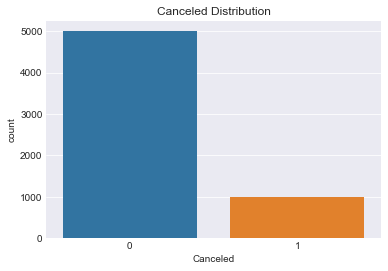

In [7]:
ax = sns.countplot(df['Canceled'])
ax.set_title('Canceled Distribution')

As we saw when running the summary statistics, the dependent variable 'Canceled' is not balanced.  There are about 5000 flights that were not canceled and only about 1000 flights that were.

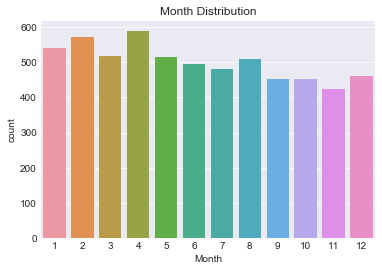

In [8]:
ax = sns.countplot(df['Month'])
ax.set_title('Month Distribution')

Flights are distributed fairly evenly among the months, but there is a slight decline from the beginning to the end of the year.

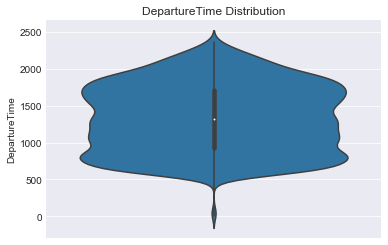

In [9]:
ax = sns.violinplot(y='DepartureTime',data=df)
ax.set_title('DepartureTime Distribution')

Departure times are fairly normally distributed with a very slight tail.

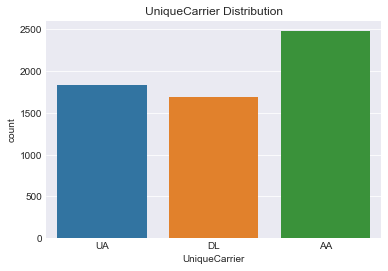

In [10]:
ax = sns.countplot(df['UniqueCarrier'])
ax.set_title('UniqueCarrier Distribution')

For UniqueCarrier, we have three values - UA, DL, and AA.  United Airlines and Delta (UA and DL respectively) both have about 1750 flights, while American Airlines (AA) has about 2500.

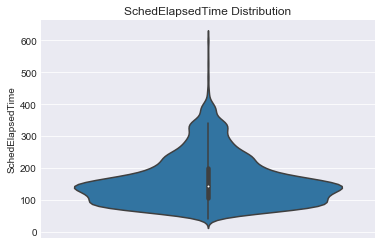

In [11]:
ax = sns.violinplot(y='SchedElapsedTime',data=df)
ax.set_title('SchedElapsedTime Distribution')

Scheduled elapsed times are highly skewed with a long right tail.  We will most likely need to transform this variable before building a model.

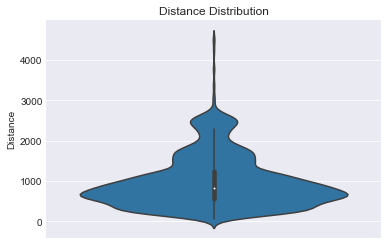

In [12]:
ax = sns.violinplot(y='Distance',data=df)
ax.set_title('Distance Distribution')

Distance is also highly right-tailed.  We will also need to transform this variable before modeling.

### Bivariate analysis

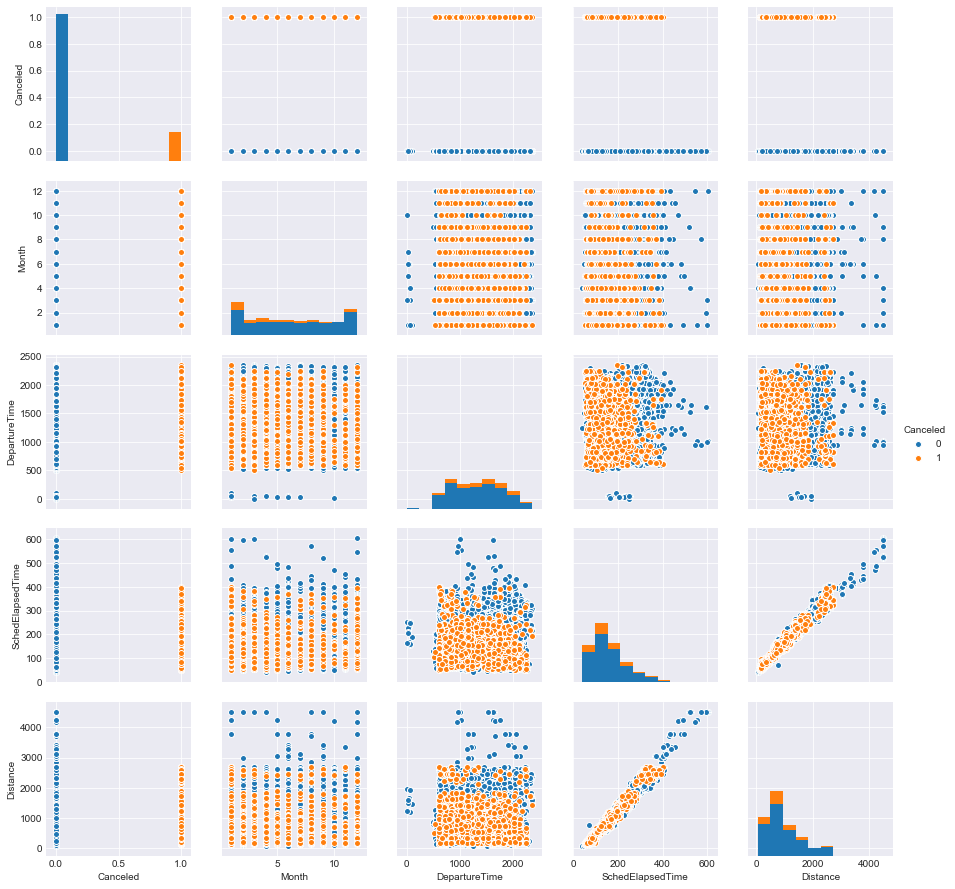

In [13]:
sns.pairplot(df[['Canceled','Month','DepartureTime','SchedElapsedTime','Distance']],hue='Canceled')

We can see that there is a strong correlation between scheduled elapsed time and distance.  This makes sense, as we would expect longer distances to take more time to cover and shorter distances to take less time.  We will only want to include one of these variables in our model.  

There also appears to be a relationship between cancellation rate and distance/scheduled elapsed time.  Longer flights do not seem to get canceled as often as shorter flights.  Though this may just be due to there being fewer long flights.  

Let's look closer at these relationships and see what the correlation between these variables is.

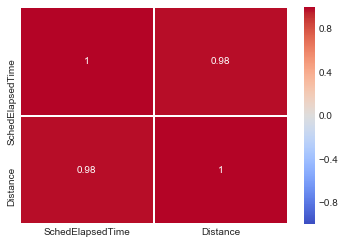

In [14]:
corr = df[['SchedElapsedTime','Distance']].corr()

sns.heatmap(corr,annot=True,cmap='coolwarm',vmin=-1,vmax=1,lw=1)

Our suspicion that SchedElapsedTime and Distance are highly correlated is confirmed.  These two variables have a correlation of 0.98.  

Next, let's use t-tests to determine if the Canceled variable has an association with either the SchedElapsedTime or Distance variables.

In [15]:
from scipy import stats

First, we will compare the mean value of the SchedElapsedTime variable between canceled and non-canceled flights.  We want to use a two-tailed t-test, because we are interested in a difference of means in either direction.  As we noticed earlier, the number of Canceled and Non-Canceled flights is not balanced.  Therefore, we will use Welch's t-test.  

This test assumes normally distributed data.  As we observed earlier, the SchedElapsedTime and Distance variables are not distributed normally.  So, first, we need to transform these variables.  we will use the Box-Cox transformation to do this.

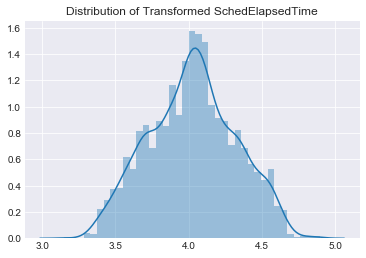

In [16]:
ax = sns.distplot(stats.boxcox(df['SchedElapsedTime'])[0])
ax.set_title('Distribution of Transformed SchedElapsedTime')

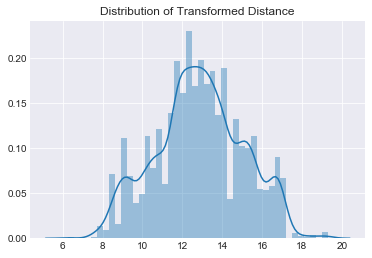

In [17]:
ax = sns.distplot(stats.boxcox(df['Distance'])[0])
ax.set_title('Distribution of Transformed Distance')

These variables are much more normally distributed after transforming them.  We should now be able to perform the t-tests using these transformed variables.  For each of these t-tests, the null hypothesis is that the means between the two groups (canceled and non-canceled flights) are the same.  The alternative hypothesis is that the mean value between the groups are not the same.  we will use an alpha of 0.05 for a confidence level of 95%.

In [18]:
t, p = stats.ttest_ind(stats.boxcox(df[df['Canceled'] == 0].SchedElapsedTime)[0], 
                       stats.boxcox(df[df['Canceled'] == 1].SchedElapsedTime)[0], 
                       equal_var=False)

print('SchedElapsedTime for Canceled vs. Non-canceled Flights')
print('------------------------------------------------------')
print('t-statistic: %s' % t)
print('p-value: %s' % p)

SchedElapsedTime for Canceled vs. Non-canceled Flights
------------------------------------------------------
t-statistic: 17.5829803162
p-value: 1.80137246458e-63


When performing the t-test for SchedElapsedTime, the t-statistic is 17.58 and the p-value is 1.80e-63.  This p-value is below our alpha of 0.05 and therefore we can reject the null hypothesis.  There is statistically significant evidence that the mean SchedElapsedTime values for canceled and non-canceled flights are not the same.

In [19]:
t, p = stats.ttest_ind(stats.boxcox(df[df['Canceled'] == 0].Distance)[0], 
                       stats.boxcox(df[df['Canceled'] == 1].Distance)[0], 
                       equal_var=False)

print('Distance for Canceled vs. Non-canceled Flights')
print('------------------------------------------------------')
print('t-statistic: %s' % t)
print('p-value: %s' % p)

Distance for Canceled vs. Non-canceled Flights
------------------------------------------------------
t-statistic: -8.44507531319
p-value: 7.54177712715e-17


When performing the t-test for Distance, the t-statistic is -8.45 and the p-value is 7.54e-17. This p-value is also below our alpha of 0.05 and therefore we can reject the null hypothesis for this test as well. There is statistically significant evidence that the mean Distance values for canceled and non-canceled flights are not the same.  

We stated earlier that we only want to include one of these two variables at most in our model  The magnitude of the t-statistic for the t-test involving SchedElapsedTime is higher than for the test involving Distance.  Therefore, we will consider SchedElapsedTime for inclusion in the model and not use Distance.

Next, let's see if there are relationships between the carrier ID and the other variables.  

We will start by performing a chi-squared test for independence between UniqueCarrier and Canceled.  The null hypothesis is that these two variables have no association.  The alternative hypothesis assumes that there is an association between the two variables.  We will select an alpha of 0.05, meaning that this test should provide results at a 95% confidence level. 

In [20]:
def print_chi2(df, col1, col2):
    obs = pd.crosstab(df[col1], df[col2])

    chi2, p, dof, expected = stats.chi2_contingency(obs)

    print('%s vs. %s' % (col1, col2))
    print('------------------------------')
    print('Chi-squared Test Statistic: %s' % chi2)
    print('P-value: %s' % p)
    print('Degrees of Freedom: %s\n' % dof)
    
print_chi2(df, 'Canceled', 'UniqueCarrier')

Canceled vs. UniqueCarrier
------------------------------
Chi-squared Test Statistic: 55.6952351721
P-value: 8.05254848157e-13
Degrees of Freedom: 2



We get a chi-squared test statistic of 55.7 with 2 degrees of freedom, which produces a p-value of 8.05e-13.  This is well below our alpha of 0.05, so we can safely reject the null hypothesis that there is no association between these two variables.  There is statistically significant evidence that there is a relationship between the unique carrier ID and cancellation rate.  

Let's dig further into this and see which airlines are more likely to have canceled flights.

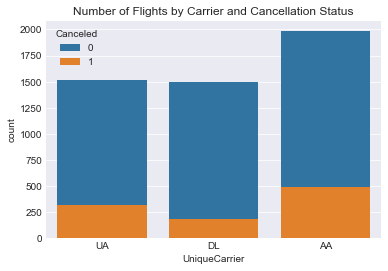

In [21]:
ax = sns.countplot(x='UniqueCarrier',data=df,hue='Canceled',dodge=False)
ax.set_title('Number of Flights by Carrier and Cancellation Status')

In [22]:
pd.crosstab(df['Canceled'],df['UniqueCarrier'])

UniqueCarrier,AA,DL,UA
Canceled,,,
0,1983,1499,1518
1,493,189,318


If going strictly by raw numbers of canceled flights, American Airlines leads the pack with 493, compared with 318 and 189 for United and Delta respectively.  However, American also has more flights overall.  Let's take a look at the percentages of each carrier's flights that are canceled instead of just the raw counts.

In [23]:
pd.crosstab(df['Canceled'],df['UniqueCarrier']).apply(lambda r: r/r.sum(), axis=0)

UniqueCarrier,AA,DL,UA
Canceled,,,
0,0.800889,0.888033,0.826797
1,0.199111,0.111967,0.173203


When looking at percentages, the airlines finish in the same order as the raw counts.  American cancels the most of their flights with about 20%, where United and Delta cancel about 17% and 11% of their flights respectively.  So, according to the data that we have, a flight is more likely to be canceled if it is operated by American Airlines than either of the other two airlines.  

On the other hand, Delta has a cancellation rate that is only slightly over half of that of either American or United.  Only about 11% of Delta's flights get canceled, compared with 20% and 17% for American and United respectively.  In this sense, Delta is the most reliable of these three (at least in the sample of flights that is accounted for by this data).

Now, let's compare Month and UniqueCarrier.

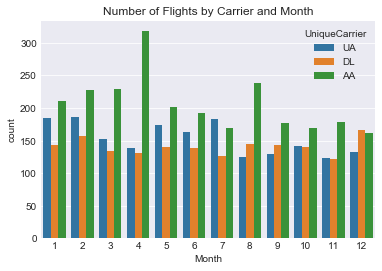

In [24]:
ax = sns.countplot(x='Month',data=df,hue='UniqueCarrier')
ax.set_title('Number of Flights by Carrier and Month')

It's a bit difficult to tell if there is a relationship between Month and UniqueCarrier from just looking at the countplot.  American Airlines appears to be on a bit of a different monthly schedule than the other two airlines, but this could just be noise.

In [25]:
print_chi2(df, 'Month', 'UniqueCarrier')

Month vs. UniqueCarrier
------------------------------
Chi-squared Test Statistic: 96.3835626734
P-value: 2.74633914661e-11
Degrees of Freedom: 22



Since Month is an ordinal variable and UniqueCarrier is a categorical variable, we can use a chi-squared test for independence with these variables.  When we do, we get a test statistic of 96.38 with 22 degrees of freedom.  This produces a p-value of 2.75e-11, which is below our alpha of 0.05.  We can reject the null hypothesis that these two variables are not related.  There is statistically significant evidence that Month and UniqueCarrier are not independent of each other.

We will need to use ANOVA to compare UniqueCarrier with DepartureTime and SchedElapsedTime, as we will have more than 2 groups to compare (since there are 3 distinct carrier codes).

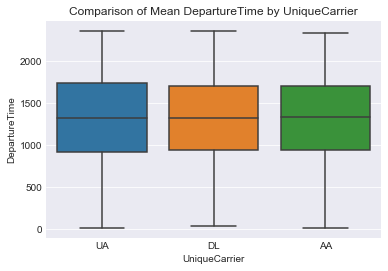

In [26]:
ax = sns.boxplot(x='UniqueCarrier',y='DepartureTime',data=df)
ax.set_title('Comparison of Mean DepartureTime by UniqueCarrier')

Looking at the boxplot, it does not appear that there is a relationship between DepartureTime and UniqueCarrier.  Let's run an ANOVA to verify that though.

In [27]:
f, p = stats.f_oneway(df[df['UniqueCarrier'] == 'AA'].DepartureTime,
                      df[df['UniqueCarrier'] == 'DL'].DepartureTime,
                      df[df['UniqueCarrier'] == 'UA'].DepartureTime)

print('DepartureTime for AA vs. DL vs. UA Flights')
print('------------------------------------------------------')
print('F-statistic: %s' % t)
print('p-value: %s' % p)

DepartureTime for AA vs. DL vs. UA Flights
------------------------------------------------------
F-statistic: -8.44507531319
p-value: 0.612742978025


When comparing flights for the mean DepartureTime for the three different airlines, we get an F-statistic of -8.45 and a p-value of 0.61.  This p-value is greater than our alpha of 0.05, so we cannot reject the null hypothesis that the means among these groups are the same.

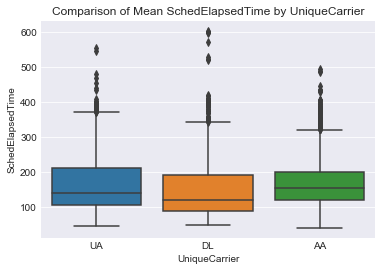

In [28]:
ax = sns.boxplot(x='UniqueCarrier',y='SchedElapsedTime',data=df)
ax.set_title('Comparison of Mean SchedElapsedTime by UniqueCarrier')

Looking at the boxplot for SchedElapsedTime vs. UniqueCarrier, it again does not look like there is a relationship.  However, there are lots of outliers that could cause issues.

In [29]:
f, p = stats.f_oneway(stats.boxcox(df[df['UniqueCarrier'] == 'AA'].SchedElapsedTime)[0],
                      stats.boxcox(df[df['UniqueCarrier'] == 'DL'].SchedElapsedTime)[0],
                      stats.boxcox(df[df['UniqueCarrier'] == 'UA'].SchedElapsedTime)[0])

print('SchedElapsedTime for AA vs. DL vs. UA Flights')
print('------------------------------------------------------')
print('F-statistic: %s' % t)
print('p-value: %s' % p)

SchedElapsedTime for AA vs. DL vs. UA Flights
------------------------------------------------------
F-statistic: -8.44507531319
p-value: 0.0


When performing an ANOVA for SchedElapsedTime (after transforming it) and UniqueCarrier, we get an F-statistic of -8.45 and a p-value of 0.  This is obviously less than our alpha of 0.05, meaning we can reject the null hypothesis that the means of these groups are the same.  However, this result may have been influenced by the outliers that we noticed earlier.

We also need to compare DepartureTime with cancellation rate.

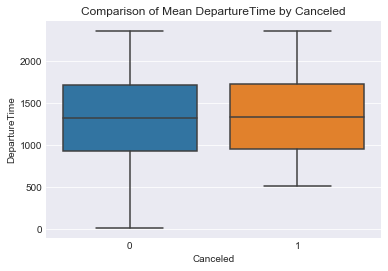

In [30]:
ax = sns.boxplot(x='Canceled',y='DepartureTime',data=df)
ax.set_title('Comparison of Mean DepartureTime by Canceled')

The mean departure time appears to be similar for canceled and non-canceled flights, although the standard deviation is larger for non-canceled flights.  Let's run a t-test to see if that is actually the case.

In [31]:
t, p = stats.ttest_ind(stats.boxcox(df[df['Canceled'] == 0].DepartureTime)[0], 
                       stats.boxcox(df[df['Canceled'] == 1].DepartureTime)[0], 
                       equal_var=False)

print('Departure Time for Canceled vs. Non-canceled Flights')
print('------------------------------------------------------')
print('t-statistic: %s' % t)
print('p-value: %s' % p)

Departure Time for Canceled vs. Non-canceled Flights
------------------------------------------------------
t-statistic: 19.7855672471
p-value: 1.14937551898e-78


When running a t-test, we get a t-statistic of 19.79 and a p-value of 1.15e-78.  This is less than our alpha of 0.05, so we can reject the null hypothesis that the mean departure time is the same between canceled and non-canceled flights.

## Feature Engineering  
### Variable Transformation

Now that we have explored our data, it is time to modify it.  We will be encapsulating all of these steps in a function later. For now, we can create a copy of the original dataframe in order to test while having the original data to fall back on in case we make any mistakes.

In [32]:
df2 = df.copy()

First, we need to perform the transformation on SchedElapsedTime that was discussed earlier.  The transformed values will be stored in a new column called SchedElapsedTime_transform.  

In [33]:
df2['SchedElapsedTime_transform'] = stats.boxcox(df2['SchedElapsedTime'])[0]

df2.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,SchedElapsedTime_transform
0,1,12,814,UA,134,0,0,679,3.979778
1,1,12,830,DL,90,0,0,214,3.716421
2,1,1,1835,UA,213,0,0,1605,4.275034
3,1,4,1730,AA,80,0,0,235,3.636706
4,1,7,1442,UA,103,0,0,413,3.806725


We can also remove the columns that were noted earlier as well as the original SchedElapsedTime column to simplify things.

In [34]:
df2.drop(['ArrDelay','DepDelay','Distance','SchedElapsedTime'],axis=1,inplace=True)

In [35]:
df2.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime_transform
0,1,12,814,UA,3.979778
1,1,12,830,DL,3.716421
2,1,1,1835,UA,4.275034
3,1,4,1730,AA,3.636706
4,1,7,1442,UA,3.806725


### Feature Creation

We should also replace the UniqueCarrier field with dummy variables, as was noted earlier.

In [36]:
df2 = pd.get_dummies(df2)

In [37]:
df2.head()

,Canceled,Month,DepartureTime,SchedElapsedTime_transform,UniqueCarrier_AA,UniqueCarrier_DL,UniqueCarrier_UA
0,1,12,814,3.979778,0,0,1
1,1,12,830,3.716421,0,1,0
2,1,1,1835,4.275034,0,0,1
3,1,4,1730,3.636706,1,0,0
4,1,7,1442,3.806725,0,0,1


Now, let's encapsulate all of the previous data modification steps into a function that can be re-used later.

In [38]:
def clean_data(df):
    # Create a copy of the original dataframe so the original is not modified
    df2 = df.copy()
    
    # Transform SchedElapsedTime
    df2['SchedElapsedTime_transform'] = stats.boxcox(df2['SchedElapsedTime'])[0]

    # Drop unnecessary columns
    df2.drop(['ArrDelay','DepDelay','Distance','SchedElapsedTime'],axis=1,inplace=True)
    
    # Create dummy variables
    df2 = pd.get_dummies(df2)
    
    # Return cleaned dataframe
    return df2

We can test the data cleaning function by creating another copy of the original dataframe and comparing it with df2.

In [39]:
df1 = clean_data(df)

In [40]:
test = (df1 == df2)
test.drop_duplicates(inplace=True)
test.head()

,Canceled,Month,DepartureTime,SchedElapsedTime_transform,UniqueCarrier_AA,UniqueCarrier_DL,UniqueCarrier_UA
0,True,True,True,True,True,True,True


The new dataset df1 is an exact duplicate of df2.  This means that the clean_data() function works properly.  

## Model Creation

Now that the data has been explored and cleaned, we can begin the process of building a model.  First we need to create our train and test datasets.  We will hold out 20% of the data as a test set and use the rest to train the model.  We will also split the dependent variable ('Canceled') out from the independent variables.  This will result in 4 new variables: X_train, X_test, y_train, and y_test.

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
y = df1['Canceled']
X = df1.drop('Canceled',axis=1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=888)

In order to avoid overfitting the model, we will use stratified k-fold cross validation on the training dataset.  We will start by using 10 folds and adjust accordingly if model computation time is too lengthy.

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

First, we need to create the cross validation object.

In [45]:
kfold = StratifiedKFold(n_splits=10, random_state=888)

### Logistic Regression

Now we can create the model.  We will try using logistic regression first.  Since the dependent variable is not distributed evenly, we will used balanced weighting.  

In order to constrain the scope of this project, we will simply build the model using all of the remaining independent variables.  However, in an ideal situation more time would be spent on feature selection using algorithms such as LASSO or stepwise selection.

In [46]:
lr_model = LogisticRegressionCV(cv=kfold,class_weight='balanced',random_state=888)
lr_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced',
           cv=StratifiedKFold(n_splits=10, random_state=888, shuffle=False),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=888, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

There are many metrics that can be used to evaluate a model.  Given that the dependent variable in this case is unbalanced, accuracy is probably not the best metric to use in model evaluation.  Therefore, we will also look at other metrics such as logarithmic loss and area under the ROC curve.

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, confusion_matrix, classification_report

In [48]:
def print_eval_scores(model, X_train, y_train, cv):
    accuracy = cross_val_score(model, X_train, y_train, cv=cv,scoring='accuracy')
    log_loss = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_log_loss')
    roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

    print('Mean Accuracy: %s' % accuracy.mean())
    print('Mean Log Loss: %s' % log_loss.mean())
    print('Mean Area Under ROC Curve: %s' % roc_auc.mean())
    
print_eval_scores(lr_model, X_train, y_train, kfold)

Mean Accuracy: 0.590831891993
Mean Log Loss: -0.66432446031
Mean Area Under ROC Curve: 0.635162975792


The mean accuracy of this model across the ten folds used in cross validation is about 58.7%.  This is somewhat mediocre, but as was noted earlier, accuracy is not necessarily the most relevant model evaluation metric in this circumstance.  

The mean log loss is also somewhat mediocre at 0.66.  

The area under the ROC curve of 0.64 is better than random (0.5 is as good as random), but perhaps we can do better with another modeling algorithm.  

In an ideal scenario, we would now try to improve this model by tuning the hyperparameters.  In order to constrain the scope of this project, we will forego this step.  For now, let's look at how the model does with the test dataset and evaluate a couple other modeling algorithms.

In [49]:
lr_model.score(X_test,y_test)

0.58999999999999997

The accuracy score for the test set is very close to the mean accuracy produced by cross validation on the train set.  That's a good sign, as it indicates that the model generalizes well to new data.

In [50]:
y_pred_lr = lr_model.predict(X_test)

In [51]:
print(classification_report(y_test, y_pred_lr))

             precision    recall  f1-score   support

          0       0.88      0.58      0.70       984
          1       0.25      0.63      0.36       216

avg / total       0.77      0.59      0.64      1200



The average precision for this model is 0.76, which is decent.  But when looking closer, we can see that the precision for values of 0 is really good (0.87) and for values of 1 it is pretty bad (0.24).  

The recall of 0.58 is somewhat middle of the road.  

Let's take a look at the confusion matrix to more easily visualize what's going on here.

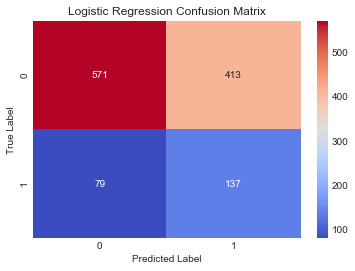

In [52]:
lr_cm = confusion_matrix(y_test,y_pred_lr)

ax = sns.heatmap(lr_cm,annot=True,cmap='coolwarm',fmt='.0f')
ax.set_title('Logistic Regression Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

When looking at the confusion matrix, we can see that this model produced lots of true negatives (568), but almost as many false positives (416).  When comparing those numbers with the number of false negatives (82) and true positives (134), it appears that this model may be predicting too many flight cancellations.  If we were not constraining the scope of this project, a next step might be to make adjustments to the weights of the model.  For now though, let's persist this model using python's pickle library in case we want to include it in our final data pipeline function and move on to a different classification algorithm.

In [53]:
import pickle
lr_model_pickled = pickle.dumps(lr_model)

### Random Forest Classifier

Next, we will build a model using a random forest classifier.  Once again, we will refrain from additional feature selection and hyperparameter tuning in order to constrain the scope of this project.

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rfc_model = RandomForestClassifier(n_estimators=100, random_state=888,class_weight='balanced')
rfc_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=888,
            verbose=0, warm_start=False)

In [56]:
print_eval_scores(rfc_model, X_train, y_train, kfold)

Mean Accuracy: 0.801458072011
Mean Log Loss: -0.697041450276
Mean Area Under ROC Curve: 0.623389627037


The random forest produced a much higher accuracy than the logistic regression model, but again accuracy is not necessarily the best evaluation metric when the response variable is as unbalanced as ours.  This is clear when looking at the mean log loss and area under the ROC curve, as these metrics are both slightly worse for the random forest than for logisitic regression.  

Let's take a look at how this model generalizes to the test set.

In [57]:
rfc_model.score(X_test,y_test)

0.80083333333333329

The RFC model produces an accuracy score of about 80.1% for both the train and test sets, so it does seem to generalize well.

In [58]:
y_pred_rfc = rfc_model.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred_rfc))

             precision    recall  f1-score   support

          0       0.83      0.95      0.89       984
          1       0.35      0.12      0.18       216

avg / total       0.75      0.80      0.76      1200



When first looking at the overall precision and recall for this model it appears to be performing really well.  But when looking closer, we can see that the precision and recall are excellent for predictions of 0 and poor for predictions of 1.  Lt's take a look at the confusion matrix to see it a little more clearly.

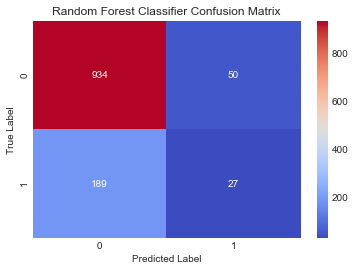

In [60]:
rfc_cm = confusion_matrix(y_test,y_pred_rfc)

ax = sns.heatmap(rfc_cm,annot=True,cmap='coolwarm',fmt='.0f')
ax.set_title('Random Forest Classifier Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

When looking at the confusion matrix, it is clear that this model is just predicting that nearly all (94% to be precise) of the flights will not be canceled.  So this model has the opposite problem of the logistic regression model.  Canceled flights were being over-predicted in that case and they are being under-predicted in this case.  

In order to determine which of these models is more useful, the context of the problem needs to be taken into account.  In this case, is it better to think that a flight will be canceled and have it take off as scheduled or to think that a flight will occur and have it be canceled.  I would prefer the first option (as I think most people would).  This means that predicting too many cancellations is preferable to predicting too many non-canceled flights.  Therefore, the logistic regression model would probably be a beter option than the random forest classifier model.  

Again, we would normally tune the hyperparameters for the RFC model (e.g. minimum samples per split, minimum samples per leaf, maximum leaf nodes, etc.) at this time in order to try and get a more useful model, but we will refrain from doing that in order to constrain the scope of the project.  Let's see if we can outperform the logistic regression model using k-nearest neighbors.

### K-Nearest Neighbors

In [61]:
from sklearn.neighbors import KNeighborsClassifier

Normally, we would loop through multiple different numbers of neighbors to use when creating a k-NN classifier and determine which value is optimal.  To constrain the scope of this project, we will just use a value of 5 for now.

In [62]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [63]:
print_eval_scores(knn_model, X_train, y_train, kfold)

Mean Accuracy: 0.814587897879
Mean Log Loss: -2.2647147457
Mean Area Under ROC Curve: 0.571234260682


When running our k-NN model on the test data set using 10 fold stratified cross validation, we get a mean accuracy score of 81.5%.  This is the highest accuracy we have seen so far.  However, highlighting the earlier warning about relying solely on the accuracy score, we can see that the log loss is terrible and the area under the ROC curve is the worst of the three models as well.  This is probably not the optimal model out of the three, but let's look at some additional metrics around its performance on the test set to see if we can find out more about what this model is doing.

In [64]:
knn_model.score(X_test,y_test)

0.80249999999999999

The accuracy is again similar between the train and test sets, so the model does appear to generalize well.

In [65]:
y_pred_knn = knn_model.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred_rfc))

             precision    recall  f1-score   support

          0       0.83      0.95      0.89       984
          1       0.35      0.12      0.18       216

avg / total       0.75      0.80      0.76      1200



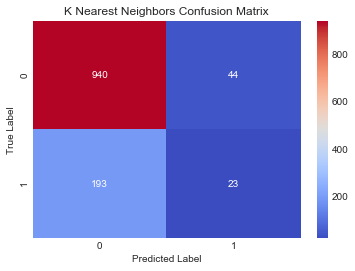

In [67]:
knn_cm = confusion_matrix(y_test,y_pred_knn)

ax = sns.heatmap(knn_cm,annot=True,cmap='coolwarm',fmt='.0f')
ax.set_title('K Nearest Neighbors Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

When looking at the precision and recall as well as the confusion matrix, the results look similar to the random forest classifier.  The k-NN model appears to be classifying even more of the flights as non-canceled though, which explains why the performance metrics look similar, but slightly worse.  

Again, we would normally attempt to optimize this model by tuning the hyperparameters, but will refrain from doing so for the purposes of this project.

### Model Selection and Encapsulation

Given that false positives are more palatable than false negatives for this problem, we will select the logistic regression model.  Despite having a lower accuracy score than the other two models that were trained, this model seems to suit our needs the best.  

Next, we will encapsulate the entire pipeline from data cleaning to modeling predictions in a function.  This will make it easy to evaluate new flights and predict whether or not thye will be canceled.

In [68]:
def predict_cancellations(df):
    # Clean data
    df1 = clean_data(df)
    
    # Drop 'Canceled' column if it exists
    if 'Canceled' in df1.columns:
        df1.drop('Canceled',axis=1,inplace=True)
        
    # Load pickled logistic regression model
    clf = pickle.loads(lr_model_pickled)
    
    # Generate and return predictions
    y_pred = clf.predict(df1)
    return y_pred

We can test this function by passing the original dataset and checking to see that a vector of predictions for the Canceled variable is returned.  We will also append these predictions to the original dataframe as a new column and export it to a csv file.

In [69]:
y_pred_func = predict_cancellations(df)

y_pred_func

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [70]:
df['Predictions'] = y_pred_func

df.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,Predictions
0,1,12,814,UA,134,0,0,679,0
1,1,12,830,DL,90,0,0,214,0
2,1,1,1835,UA,213,0,0,1605,1
3,1,4,1730,AA,80,0,0,235,1
4,1,7,1442,UA,103,0,0,413,1


In [71]:
df.to_csv('flight_delay_predictions.csv',index=False)

## Future Work

When analyzing the flight delays dataset, we traversed through the full data science pipeline of understanding the data, preparing the data, bulding models, evaluating and selecting models, and finally preparing the model for deployment.  With most projects, there is usually room for further work when they are "done."  This project is no exception.  With the given time constraints, decisions were made to constrain the scope at certain points in the process.  This leaves lots of room for future improvements to this work.  

Expanded feature engineering is one area of possible future work.  For example, the DepartureTime variable could be modified or turned into new features.  Perhaps binning it into hours or other chunks of the day would produce a better model than leaving it in its current form.  

Feature selection is another area where further work could be done.  We decided to exclude certain variables while performing exploratory data analysis, but we may have produced more useful models had we not included all of the remaining features.  Algorithms such as Grid Search, LASSO, or Stepwise selection could yield a more optimized feature set.  

Model tuning is probably the lowest hanging fruit in terms of additional work that could be done with this dataset.  We chose to use almost the default parameter values for each of our three models just due to the time constraint of completing this project in a couple days after work.  It is highly unlikely that these are the optimized configurations for these models though.  There are so many things that could be tuned.  Different weights could be evaluated.  The depth and breadth of the random forest could be played with.  Additional distance metrics and values of k could be examined for the k-nearest neighbors model.  A lot of time could be spent on this area.